In [13]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from scipy.ndimage import interpolation
from sklearn.model_selection import train_test_split
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


**Load the Dataset**

In [2]:
X = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X.shape

(42000, 785)

In [4]:
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_test.shape

(28000, 784)

In [6]:
y = X['label']
y.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [7]:
X.drop(['label'], axis=1, inplace=True)
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Check a sample image**

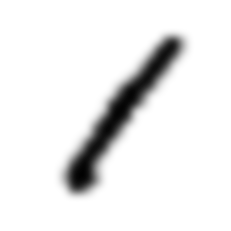

In [12]:
some_digit = np.array(X.iloc[[0]])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="bicubic")
plt.axis("off")
plt.show()

**Data Augmentation**

*Generate more training data by shifting the given images 1 pixel in up/down/left/right directions to generate 4 more training samples for each input image.*

*Shift 1 pixel down*

In [16]:
#shift one pixel in all four direction to generate 4 more training samples for each input image.
X_aug_down = interpolation.shift(np.array(X).reshape(42000,28,28), [0,1,0], cval=0)
X_aug_down.shape
X_aug_up = interpolation.shift(np.array(X).reshape(42000,28,28), [0,-1,0], cval=0)
X_aug_up.shape
X_aug_right = interpolation.shift(np.array(X).reshape(42000,28,28), [0,0,1], cval=0)
X_aug_right.shape
X_aug_left = interpolation.shift(np.array(X).reshape(42000,28,28), [0,0,-1], cval=0)
X_aug_left.shape

(42000, 28, 28)

In [17]:
X_temp = np.concatenate((X_aug_down, X_aug_up, X_aug_right, X_aug_left))
X_temp.shape

(168000, 28, 28)

*Augmented training dataset generated and stored in X_aug and y_aug.*

In [18]:
X_aug = np.concatenate((X, X_temp.reshape(168000, 784)))
X_aug.shape

(210000, 784)

In [19]:
y_aug = np.concatenate((y, y, y, y, y))
y_aug.shape

(210000,)

**Split into Training and Validation Sets**

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size=0.2)

**Training ResNet-34**

In [22]:
import tensorflow as tf
from tensorflow import keras
from functools import partial

***ResNet-34*** *is the ResNet with 34 layers (only counting convolutional layers and the fully connected layer) containing 3 residual units that output 64 feature maps, 4 residual units with 128 maps, 6 residual units with 256 maps, and 3 residual units with 512 maps.*

In [23]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)

In [25]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
            
    def get_config(self):
        return
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [26]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [28]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)          7

In [30]:
model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=10, 
          validation_data=(X_val.reshape(-1, 28, 28, 1), y_val),
          callbacks=[early_stopping_cb])

Epoch 1/10
5250/5250 [==============================] - 155s 28ms/step - loss: 0.2183 - accuracy: 0.9398 - val_loss: 0.2940 - val_accuracy: 0.9266
Epoch 2/10
5250/5250 [==============================] - 144s 27ms/step - loss: 0.0653 - accuracy: 0.9815 - val_loss: 0.0816 - val_accuracy: 0.9789
Epoch 3/10
5250/5250 [==============================] - 144s 27ms/step - loss: 0.0495 - accuracy: 0.9861 - val_loss: 0.0604 - val_accuracy: 0.9848
Epoch 4/10
5250/5250 [==============================] - 144s 28ms/step - loss: 0.0391 - accuracy: 0.9899 - val_loss: 0.0227 - val_accuracy: 0.9935
Epoch 5/10
5250/5250 [==============================] - 144s 27ms/step - loss: 0.0321 - accuracy: 0.9915 - val_loss: 0.0361 - val_accuracy: 0.9909
Epoch 6/10
5250/5250 [==============================] - 145s 28ms/step - loss: 0.0249 - accuracy: 0.9933 - val_loss: 0.0171 - val_accuracy: 0.9953
Epoch 7/10
5250/5250 [==============================] - 143s 27ms/step - loss: 0.0232 - accuracy: 0.9940 - val_loss: 0

**Prediction on the Test Set**

In [31]:
predictions = np.argmax(model.predict(X_test.values.reshape(-1, 28, 28, 1)), axis=-1)

output = pd.DataFrame({'ImageId': list(range(1, len(X_test)+1)), 'Label': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


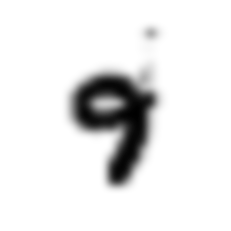

Prediction: 9


In [42]:

import random
index = random.randint(0, 27999) # index of the image in the test set
plt.imshow(X_test.values[index].reshape(28, 28), cmap = mpl.cm.binary, interpolation="bicubic")
plt.axis("off")
plt.show()
print(f'Prediction: {predictions[index]}')